In [2]:
!pip install torchvision
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import mean_squared_error

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
### Step 1: Prepare MNIST Dataset with digits 1 and 8
def prepare_mnist_data(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    transform = transforms.ToTensor()
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    digit_1_indices = [i for i, (img, label) in enumerate(mnist) if label == 1][:5000]
    digit_8_indices = [i for i, (img, label) in enumerate(mnist) if label == 8][:5000]
    selected_indices = digit_1_indices + digit_8_indices
    subset = Subset(mnist, selected_indices)
    images, labels = [], []
    for img, label in subset:
        images.append(img.view(-1))
        labels.append(label)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.3, random_state=seed, stratify=labels
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_mnist_data()
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

In [4]:
### Step 2: Kernel PCA Functions (RBF and Polynomial Kernel)
def rbf_kernel_torch(x, X_train, gamma):
    diff = X_train - x
    dists = torch.sum(diff ** 2, dim=1, keepdim=True).T
    return torch.exp(-gamma * dists)

def poly_kernel_torch(x, X_train, degree=3, c=1.0, alpha=1.0):
    dot_product = torch.matmul(X_train, x.T)
    return (alpha * dot_product + c) ** degree
    
def center_kernel(K):
    N = K.shape[0]
    one_N = np.ones((N, N)) / N
    return K - one_N @ K - K @ one_N + one_N @ K @ one_N

def kernel_pca(K, M=50):
    Kc = center_kernel(K)
    eigvals, eigvecs = np.linalg.eigh(Kc)
    idx = np.argsort(eigvals)[::-1][:M]
    lambdas = eigvals[idx]
    alphas = eigvecs[:, idx]
    alphas = alphas / np.sqrt(lambdas)
    return Kc, alphas, lambdas

def compute_kernel(X1, X2, kernel_type='rbf', gamma=0.01, c=1.0):
    if kernel_type == 'rbf':
        return pairwise_kernels(X1, X2, metric='rbf', gamma=gamma)
    elif kernel_type == 'poly':
        return pairwise_kernels(X1, X2, metric='poly', degree=3, coef0=c)
    else:
        raise ValueError("Unsupported kernel type")

def project_kernel(X_test, X_train, alphas, gamma, kernel_type='rbf', c=1.0):
    print('Projecting Kernel')
    K_test = compute_kernel(X_test, X_train, kernel_type, gamma, c)
    return K_test @ alphas

In [5]:
### Step 3: Exact Pre-image Reconstruction using Gradient Descent
def reconstruct_kernel_pca_exact(z_n, alphas, lambdas, X_train, gamma, lr=0.01, steps=25,
                                  kernel_type='rbf', degree=3, coef0=10.0, alpha=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    z_n = torch.tensor(z_n, dtype=torch.float32).to(device)
    alphas = torch.tensor(alphas, dtype=torch.float32).to(device)
    lambdas = torch.tensor(lambdas, dtype=torch.float32).to(device)

    x_hat = torch.randn((1, X_train.shape[1]), requires_grad=True, device=device)
    optimizer = torch.optim.Adam([x_hat], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        if kernel_type == 'rbf':
            k = rbf_kernel_torch(x_hat, X_train, gamma)  # (1, n_samples)
        elif kernel_type == 'poly':
            k = poly_kernel_torch(x_hat, X_train, degree=degree, c=c, alpha=alpha)
        else:
            raise ValueError("Unsupported kernel type") 
        
        z_est = (k @ alphas) / torch.sqrt(lambdas)  # (1, n_components)
        loss = torch.nn.functional.mse_loss(z_est.squeeze(), z_n)
        loss.backward()
        optimizer.step()

    return x_hat.detach().cpu().numpy().squeeze()

def batch_kernel_pca_reconstruct(Z, alphas, lambdas, X_train, gamma, lr=0.01, steps=1000, num_samples=5):
    reconstructions = []
    selected_indices = np.random.choice(Z.shape[0], size=num_samples, replace=False)
    for idx in selected_indices:
        z_n = Z[idx]
        x_hat = reconstruct_kernel_pca_exact(z_n, alphas, lambdas, X_train, gamma, lr, steps)
        reconstructions.append((X_train[idx], x_hat))
    return reconstructions

def plot_kernel_pca_reconstructions(pairs, title="Kernel PCA: Original vs Reconstructed"):
    n = len(pairs)
    plt.figure(figsize=(2 * n, 4))
    for i, (orig, recon) in enumerate(pairs):
        plt.subplot(2, n, i + 1)
        plt.imshow(orig.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def compute_test_mse(X_test, X_train, alphas, lambdas, gamma, kernel_type, c):
    test_mse = []
    for M in range(1, 11):
        print(f'M = {M}')
        Z_test = project_kernel(X_test, X_train, alphas[:, :M], gamma, kernel_type=kernel_type, c=c)
        print(f'Number of test samples: {len(X_test)}')
        recons = [reconstruct_kernel_pca_exact(Z_test[i], alphas[:, :M], lambdas[:M], X_train, gamma) for i in range(len(X_test))]
        mse = mean_squared_error(X_test, recons)
        test_mse.append(mse)
        print(mse)
    return test_mse

def plot_mse_curve(mse_list, method_name):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), mse_list, marker='o', label=method_name)
    plt.xlabel("M (Number of Components)")
    plt.ylabel("Test MSE")
    plt.title(f"Test MSE vs. M for {method_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

1


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
/tmp/ipykernel_7296/2240592910.py:23: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(z_est.squeeze(), z_n)


2


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


3


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


4


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


5


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


6


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


7


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


8


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


9


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


10


/tmp/ipykernel_7296/2240592910.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


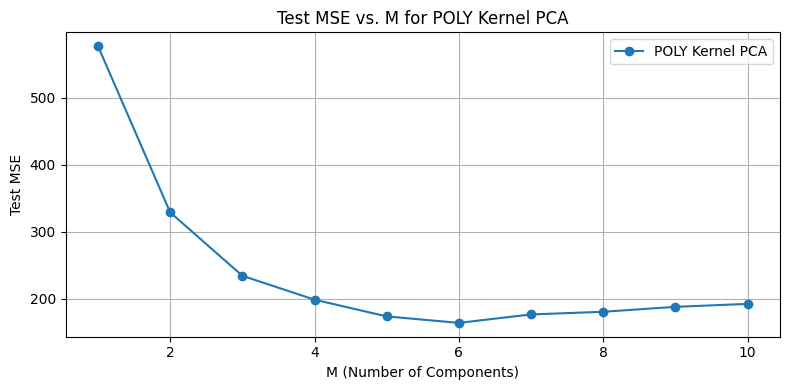

In [9]:
## Evaluation of Reconstructed Images
kernel_type = 'poly' ##or rbf
gamma = 0.01
c = 10.0

mse_scores = []

K_test = compute_kernel(X_test_np, X_test_np, kernel_type=kernel_type, gamma=gamma, c=c)

for M in range(1, 11):
    print(M)
    Kc, alphas, lambdas = kernel_pca(K_test, M=M)
    Z_test = Kc @ alphas
    recons = [reconstruct_kernel_pca_exact(Z_test[i], alphas[:, :M], lambdas[:M], X_test, gamma, c) for i in range(len(X_test))]
    mse = mean_squared_error(X_test, recons)
    mse_scores.append(mse)

plot_mse_curve(mse_scores, method_name=f"{kernel_type.upper()} Kernel PCA")

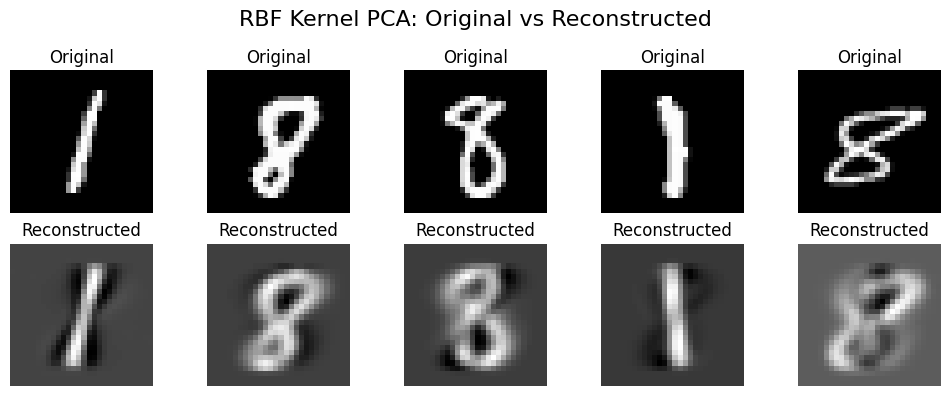

In [10]:
### Reconstruction from Kernel PCA
kernel_type = 'rbf' ## or 'poly'
gamma = 0.01
c = 10.0

K_test = compute_kernel(X_test_np, X_test_np, kernel_type=kernel_type, gamma=gamma, c=c)
Kc, alphas, lambdas = kernel_pca(K_test, M=8)
Z_test = Kc @ alphas

recon_pairs = batch_kernel_pca_reconstruct(
    Z=Z_test,
    alphas=alphas,
    lambdas=lambdas,
    X_train=X_test_np,
    gamma=gamma,
    lr=0.01,
    steps=1000,
    num_samples=5
)

plot_kernel_pca_reconstructions(recon_pairs, title=f"{kernel_type.upper()} Kernel PCA: Original vs Reconstructed")